In [1]:
data_coords = {
    0: (20, 20),
    1: (20, 40),
    2: (20, 160),
    3: (40, 120),
    4: (60, 20),
    5: (60, 80),
    6: (60, 200),
    7: (80, 180),
    8: (100, 40),
    9: (100, 120),
    10: (100, 160),
    11: (120, 80),
    12: (140, 140),
    13: (140, 180),
    14: (160, 20),
    15: (180, 60),
    16: (180, 100),
    17: (180, 200),
    18: (200, 40),
    19: (200, 160)}

data_map = {"Brighton" : {"Brighton": 0, "Bristol": 172, "Cambridge": 145, "Glasgow": 607, "Liverpool": 329,
                          "London": 72, "Manchester": 312, "Oxford": 120},
             "Bristol" : {"Brighton": 172, "Bristol": 0, "Cambridge": 192, "Glasgow": 494, "Liverpool": 209,
                          "London": 158, "Manchester": 216, "Oxford": 92},
             "Cambridge" : {"Brighton": 145, "Bristol": 192, "Cambridge": 0, "Glasgow": 490, "Liverpool": 237,
                          "London": 75, "Manchester": 205, "Oxford": 100},
             "Glasgow" : {"Brighton": 607, "Bristol": 494, "Cambridge": 490, "Glasgow": 0, "Liverpool": 286,
                          "London": 545, "Manchester": 296, "Oxford": 489},
             "Liverpool" : {"Brighton": 329, "Bristol": 209, "Cambridge": 237, "Glasgow": 286, "Liverpool": 0,
                          "London": 421, "Manchester": 49, "Oxford": 408},
             "London" : {"Brighton": 72, "Bristol": 158, "Cambridge": 75, "Glasgow": 545, "Liverpool": 421,
                          "London": 0, "Manchester": 249, "Oxford": 75},
             "Manchester" : {"Brighton": 312, "Bristol": 216, "Cambridge": 205, "Glasgow": 296, "Liverpool": 49,
                          "London": 249, "Manchester": 0, "Oxford": 194},
             "Oxford" : {"Brighton": 120, "Bristol": 92, "Cambridge": 100, "Glasgow": 489, "Liverpool": 208,
                          "London": 75, "Manchester": 194, "Oxford": 0}
            }

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rand

class GeneticAlgorithm:
    def __init__(self, data, do_plot, dtype, edge_recomb, rsm, N):
        self.data = data
        self.map_dtype = dtype
        self.do_plot = do_plot
        self.edge_recomb = edge_recomb
        self.rsm = rsm
        self.N = N

    """ generate initial population """
    def init_population(self, n):
        individuals = []

        for i in range(n):
            individuals.append(self.gen_individual())

        return individuals

    """ generate an individual """
    def gen_individual(self):
        nodes = list(self.data.keys())
        rand.shuffle(nodes)
        return nodes

    """ evaluate an individual by returning its fitness score (1 / path cost)"""
    def evaluate(self, individual):
        cost = 0

        # calculate and sum path cost to travel from node to node
        for i in range(0, len(individual)-1):
            n1 = individual[i]
            n2 = individual[i+1]
            cost += self.dist(n1, n2)

        # add cost for return
        start = individual[0]
        end = individual[len(individual)-1]
        cost += self.dist(end, start)

        return 1.0 / cost

    """ select top n individuals sorted by their fitness score"""
    def select_top(self, individuals, n):
        scores = [self.evaluate(i) for i in individuals]
        results = np.array(list(zip(individuals, scores)))
        return results[results[:,1].argsort()[::-1]][:n]

    """ select k random individuals and return the one with the highest fitness score """
    def tournament_selection(self, individuals, k):
        selection = rand.choices(individuals, k=k)
        top = self.select_top(selection, 1)
        return top[0][0]
    
    def adj_matrix(self, n):
        n_adj = {
            n[0] : set([n[1]]),
            n[len(n) - 1]: set([n[len(n) - 2]])
        }
        for i in range(1, len(n) - 1):
            n_adj[n[i]] = set([n[i - 1], n[i + 1]])

        return n_adj
            
    def union(self, n1_adj, n2_adj):
        return { n: n1_adj[n] | n2_adj[n] for n in n1_adj }

    def edge_recombination(self, n1, n2):
        n1_adj_matrix = self.adj_matrix(n1)
        n2_adj_matrix = self.adj_matrix(n2)

        adj = self.union(n1_adj_matrix, n2_adj_matrix)

        K = list()
        random_parent = rand.choice([n1, n2])
        N = random_parent[0]
        K.append(N)
        while len(K) < len(random_parent):
            adj = { n: neighbours - set([N]) for n, neighbours in adj.items() }
            N_star = None

            if (len(adj[N]) is not 0):
                neighbours_N = adj[N]
                neighbours_with_N = [ (neighbour, adj[neighbour]) for neighbour in neighbours_N ]
                sorted_neighbours = sorted(neighbours_with_N,
                                        key=lambda t: len(t[1]))
                min_len = len(sorted_neighbours[0][1])
                min_neighbours = [ n for n, neighbours in sorted_neighbours if len(neighbours) == min_len]

                N_star = rand.choice(list(min_neighbours))
            else:
                N_star = rand.choice([ n for n in random_parent if n not in K ])

            N = N_star
            K.append(N)
    
        return K
    
    """ ordered crossover """
    def crossover(self, n1, n2):
#         print(n1)

        best, other = n1, n2

        if self.evaluate(n1) < self.evaluate(n2):
            best, other = other, best

        # indices for a random subset from the best individual
        start = rand.randint(0, len(best)-1)
        end = rand.randint(0, len(best)-1)

        if(start > end): #swap indices if needed
            start, end = end, start

        if(start == end): #single element
            subset = [best[start]]
            end = end+1
        else: #otherwise return subset
            subset = best[start:end]

        # remove those already within the subset
        pruned_other = [x for x in other if x not in subset]

        new = []

        # perform crossover
        for i in range(0, start):
            new.append(pruned_other.pop(0))

        new.extend(subset)

        for i in range(end, len(best)):
            new.append(pruned_other.pop(0))

        return new
    
    """ reverse sequence mutation """
    def mutate_2(self, individual):
        start = rand.randint(0, len(individual)-1)
        end = rand.randint(0, len(individual)-1)

        if(start > end): #swap indices if needed
            start, end = end, start
            
        new = individual[:start] + list(reversed(individual[start:end])) + individual[end:]
        
        return new

    """ swap mutation """
    def mutate(self, individual):
        gene1 = rand.randint(0, len(individual)-1)
        gene2 = rand.randint(0, len(individual)-1)

        while True:
            if gene1 == gene2:
                gene2 = rand.randint(0, len(individual)-1)
            else:
                break

        new = individual.copy()

        new[gene1], new[gene2] = new[gene2], new[gene1]

        return new

    def evolve(self, _pop, N):
        new_pop = []
        k = 25
        num_elites = 1

        # add previous best to new population to guarantee the fitness cannot get worse
        best = self.select_top(_pop, num_elites)
        for individual in best:
            new_pop.append(individual[0])
            N-= 1

        #print(best)

        for i in range(N):
            pop = _pop.copy()

            # select parents
            parent1 = self.tournament_selection(pop, k)
            pop.remove(parent1)
            parent2 = self.tournament_selection(pop, k)

            # cross-over parents to create child
            if self.edge_recomb:
                child = self.edge_recombination(parent1, parent2)
            else:
                child = self.crossover(parent1, parent2)
            

            # mutate child
            if self.rsm:
                child = self.mutate_2(child)
            else:
                child = self.mutate(child)

            new_pop.append(child)

        return new_pop

    """ simple euclidean distance used as cost function """
    def dist(self, n1, n2):
        dist = 0
        if not self.map_dtype: #euclidean distance
            pos1 = np.array(self.data[n1])
            pos2 = np.array(self.data[n2])
            dist = np.linalg.norm(pos1-pos2)
        else: #get stored distance from map
            dist = self.data[n1][n2]

        return dist

    """ creates an edgelist from a path """
    def get_edges(self, path):
        for i in range(len(path)):
            if i == (len(path)-1): #connect end to start
                yield [path[i], path[0]]
            else:
                yield [path[i], path[i+1]]
                
                
    def plot(self, edges=None):
        if not self.do_plot:
            return
        #plot nodes
        graph = nx.Graph()
        
        if edges is not None:
            graph.add_edges_from(edges)
            
        if self.map_dtype:
            for n in self.data.keys():
                graph.add_node(n)
            nx.draw_networkx(graph)
        else:
            for n, p in self.data.items():
                graph.add_node(n)
                graph.node[n]['pos'] = p
            nx.draw_networkx(graph, self.data)

        plt.axhline(y=0)
        plt.axvline(x=0)
        #plt.grid()
        plt.show()

    def run(self):
        N = self.N # number of individuals to have in population
        iters = 40 # number of max consecutive iterations with no new solution
        max_iters = 100 # number of max iterations allowed overall
        
        self.plot()

        # create initial population of individuals
        individuals = self.init_population(N)

        lastval = None
        counter = 0

        iter_count = 0

        terminated = False

        while not terminated and iter_count < max_iters:
        # for iter in range(iters):
            new_individuals = self.evolve(individuals, N)
            individuals = new_individuals

            top = self.select_top(individuals, 1)[0]
            fitness = top[1]

            if lastval == fitness:
                counter += 1
            else:
                counter = 0

            iter_count += 1

            lastval = fitness

            if counter == iters:
                terminated = True

#             c_str = "(" + str(counter) + "/" + str(iters) + ")" + " (" + str(iter_count) + "/" + str(max_iters) + ")"
#             print("fitness:", fitness, c_str)

        # adequate solution found
        solution = self.select_top(individuals, 1)[0]
        path = solution[0]
        edges = list(self.get_edges(path))

        print(solution)

        self.plot(edges)
        
        return iter_count, solution


In [63]:
GA_coord_data = GeneticAlgorithm(data_coords, True, False, True, True, 50)
GA_map_data = GeneticAlgorithm(data_map, True, True, True, True, 50)

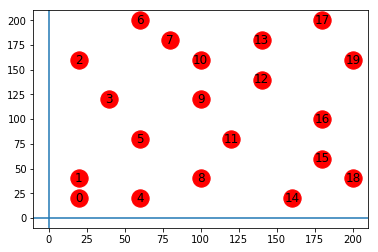

[list([0, 1, 5, 9, 3, 2, 6, 7, 10, 13, 17, 19, 12, 16, 15, 18, 14, 11, 8, 4])
 0.0010875084567679677]


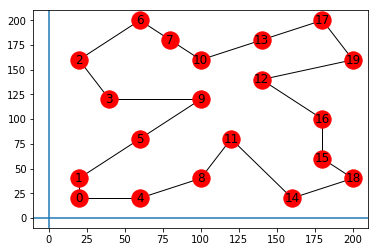

(62,
 array([list([0, 1, 5, 9, 3, 2, 6, 7, 10, 13, 17, 19, 12, 16, 15, 18, 14, 11, 8, 4]),
        0.0010875084567679677], dtype=object))

In [64]:
GA_coord_data.run()

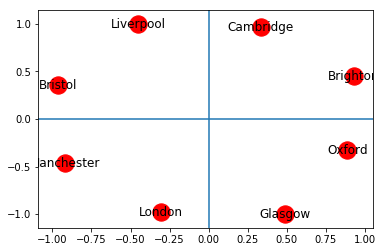

[list(['Manchester', 'Cambridge', 'London', 'Brighton', 'Oxford', 'Bristol', 'Liverpool', 'Glasgow'])
 0.0007380073800738007]


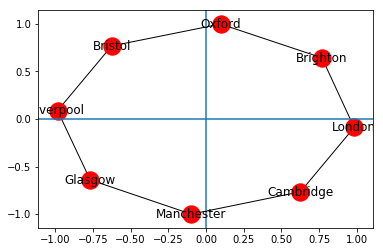

(44,
 array([list(['Manchester', 'Cambridge', 'London', 'Brighton', 'Oxford', 'Bristol', 'Liverpool', 'Glasgow']),
        0.0007380073800738007], dtype=object))

In [60]:
GA_map_data.run()

In [ ]:
import itertools
selections = [ False, True ]

# run experiments with each possible combination of crossover and mutation function,
# recording iterations until convergence and the best fitness score with varying
# values of N
for edge_recomb, rsm in itertools.product(selections, selections):
    for N in [50, 100, 200]:
        GA_coord_data = GeneticAlgorithm(data_coords, False, False, edge_recomb, rsm, N)
        GA_map_data = GeneticAlgorithm(data_map, False, True, edge_recomb, rsm, N)
        
        results_1 = GA_coord_data.run()
        results_2 = GA_map_data.run()
        
        print(edge_recomb, rsm, N)
        print(results_1[0], results_1[1][1])
        print(results_2[0], results_2[1][1])

[list([10, 13, 17, 19, 12, 9, 11, 16, 15, 18, 14, 8, 4, 0, 1, 5, 3, 2, 6, 7])
 0.0011233193529630826]
[list(['Bristol', 'Liverpool', 'Glasgow', 'Manchester', 'Cambridge', 'London', 'Brighton', 'Oxford'])
 0.0007380073800738007]
False False 50
100 0.0011233193529630826
43 0.0007380073800738007
[list([0, 1, 5, 9, 3, 2, 6, 7, 10, 12, 13, 17, 19, 16, 15, 18, 14, 11, 8, 4])
 0.0011074632050946387]
[list(['Oxford', 'Bristol', 'Liverpool', 'Glasgow', 'Manchester', 'Cambridge', 'London', 'Brighton'])
 0.0007380073800738007]
False False 100
62 0.0011074632050946387
41 0.0007380073800738007
